# Content

1. [Must Read](#1)
2. [Import Library](#2)
3. [Load Data](#3)
4. [Các phương pháp xử lí dữ liệu trước khi đưa vào mô hình](#4)
5. [Chia tập train, val](#5)
6. [Xử lí null data](#6)
7. [Phương pháp đánh giá](#10)
7. [Thử nghiệm các mô hình](#7)
8. [Dự đoán tập test và submit](#8)
9. [Kết quả quá trình](#9)

<a id=1></a> <br>
# Must read

<h1>Thử nghiệm mô hình</h1>

Đây là notebook dùng để thử nghiệm model của em sau phần Data analysis: https://www.kaggle.com/tunnguynnhanh/ml-assignment-data-analysis cho bài toán IEEE Fraud Detection

Như đã nói ở phần `Export Data`, trong quá trình làm việc với bài toán, em thường xuyên gặp tình trạng tràn ram, dẫn đến không thể chạy hết notebook để ra kết quả. Vậy nên em thường tách phần xử lý data bằng PCA, StandardScaler và Reduce_mem_usage ra một notebook ngoài và load data vào các dataset để chạy (như hình bên dưới):

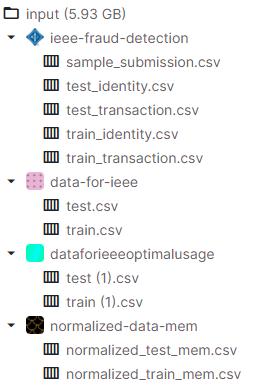

Vậy nên, trong notebook này, em chỉ nêu ra các phương pháp xử lí, model em đã dùng, em sẽ trình bày kết quả của mỗi lần thử model ở mục tương ứng. VD: mô hình XGBoost sử dụng PCA cho V cols có kết quả như thế nào, mô hình LightGBM không dùng StandardScaler có kết quả như thế nào, ... Đương nhiên, em vẫn có các kết quả submission ở trên Kaggle như hình bên dưới:

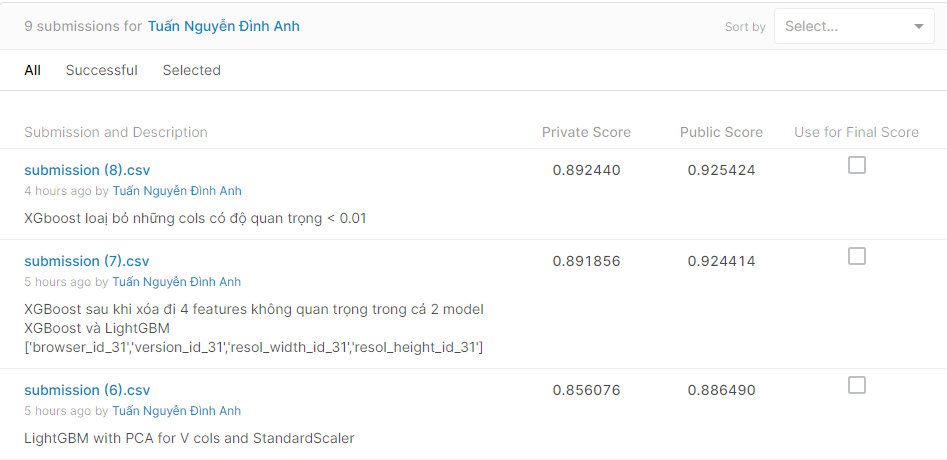

Em cảm ơn thầy và mọi người đã đọc

<a id=2></a> <br>
# Import library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn import over_sampling, under_sampling
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder, minmax_scale, StandardScaler

<a id=3></a> <br>
# Load data

Trong notebook này em sử dụng 4 dataset như hình bên dưới

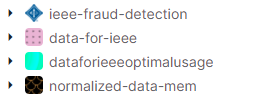

Thông tin về các dataset như sau:

**ieee-fraud-detection**: dataset của cuộc thi

**data-for-ieee**: dataset được export sau khi hoàn thành notebook `Data analysis`

**dataforieeeoptimalusage**: dataset được giảm bộ nhớ sau khi hoàn thành notebook `Data analysis`

**normalized-data-mem**: dataset với các numarical features được đi qua StandardScaler, categorical features đi qua LabelEncoder, cuối cùng là giảm bộ nhớ



In [ ]:
# data_path = "/content/drive/MyDrive/ieee-fraud-detection/"
data_path = "../input/dataforieeeoptimalusage/"

In [ ]:
# Train
train = pd.read_csv(data_path + "train (1).csv")

#Test
test = pd.read_csv(data_path + "test (1).csv")

==> Do có những dataset khi em export không để index=False nên em cần có cell này để xóa cột index đi

In [ ]:
train.drop('Unnamed0', axis=1, inplace=True)
test.drop('Unnamed0', axis=1, inplace=True)

<a id=4></a> <br>
# Các phương pháp xử lí dữ liệu trước khi đưa vào mô hình

**<h2>Cách 1: Xóa cột có độ quan trọng bằng không</h2>**

['browser_id_31','version_id_31','resol_width_id_31','resol_height_id_31']: đây là danh sách những features có độ quan trọng (`feature_importances_`) bằng 0 trong nhiều lần thử ở 2 mô hình LightGBM, XGBoost. Vậy nên em chọn đây là một cách để xử lí dữ liệu. Kết quả khi thử Cách này ở cell cuối cùng

In [ ]:
train.drop(['browser_id_31','version_id_31','resol_width_id_31','resol_height_id_31'], axis=1, inplace=True)
test.drop(['browser_id_31','version_id_31','resol_width_id_31','resol_height_id_31'], axis=1, inplace=True)

**<h2>Cách 2: Xóa những cột có độ quan trọng thấp</h2>**

`not_ok_cols` là danh sách những features có độ quan trọng nhỏ hơn 0.001. Nhận thấy sau khi thực hiện Cách 1 thì có sự cải thiện trong model, nên em để đây là cách 2 xử lí

In [ ]:
not_ok_cols = ['V95', 'id_18', 'V206', 'V177', 'M8', 'V280', 'V284', 'V268', 'V100', 'V164', 'V276', 'V71', 'V37', 'V134', 'V331', 'V174', 'V275', 'V273', 'V327', 'V292', 'V17', 'V11', 'V10', 'V214', 'id_16', 'V126', 'id_34', 'V127', 'V116', 'V299', 'V168', 'V40', 'id_12', 'V203', 'hour', 'V295', 'V306', 'V166', 'V15', 'V222', 'M7', 'V264', 'V221', 'V9', 'V303', 'V265', 'V316', 'day', 'id_28', 'V228', 'V236', 'V235', 'D9', 'D7', 'V125', 'V157', 'V211', 'V1', 'V238', 'V132', 'V148', 'V199', 'V96', 'V183', 'id_15', 'V97', 'V212', 'V104', 'V181', 'V263', 'V202', 'V118', 'V204', 'V328', 'V230', 'V182', 'V101', 'V144', 'V231', 'V176', 'V302', 'M1', 'V179', 'V325', 'V14', 'V240', 'id_29', 'V27', 'V28', 'V41', 'V65', 'V68', 'V88', 'V89', 'V241', 'V305']
train.drop(not_ok_cols, axis=1, inplace=True)
test.drop(not_ok_cols, axis=1, inplace=True)

**<h2>Cách 3: Giảm bộ nhớ dữ liệu</h2>**

Đây là hàm giảm bộ nhớ data. Khi mới load vào từ file csv, dữ liệu thường có usage rất lớn, nên em tham khảo hàm này để giảm bộ nhớ data

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

**<h2>Cách 4: PCA for V cols</h2>**

Sau những lần chạy LightGBM và XGBoost thì khi nhìn vào độ quan trọng của dữ liệu, em thấy các cột V tập trung rất nhiều ở phía cuối. Vậy nên em nghĩ rằng việc giảm số lượng features V đi sẽ làm nhẹ model, vì còn ít features hơn và sẽ không ảnh hưởng đến hoặc làm tốt model lên. Kết quả lại đi ngược với mong đợi. Chi tiết ở cell cuối cùng

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt/notebook#Concating-dfs-to-get-PCA-of-V-features
def PCA_change(df, cols, n_components, prefix, rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

Lấy ra các cột V_features

In [ ]:
# all_v_cols = ["V{}".format(i) for i in range(1, 340) if i != 107]
# print(all_v_cols)
# existed_v_cols = [train.columns.get_loc(c) for c in all_v_cols if c in train]
existed_v_cols = train.columns[55:393]
existed_v_cols
# print(existed_v_cols)

Áp dụng PCA cho cả tập train và test. Theo em nghĩ, phải nối cột V của tập `train` và tập `test` lại rồi mới áp dụng PCA, nhưng do bị tràn ram, em không thử được nên áp dụng riêng

In [ ]:
for col in existed_v_cols:
    train[col] = train[col].fillna((train[col].min() - 2))
    train[col] = (minmax_scale(train[col], feature_range=(0,1)))

    
train = PCA_change(train, existed_v_cols, prefix="V_", n_components=30)

for col in existed_v_cols:
    test[col] = test[col].fillna((test[col].min() - 2))
    test[col] = (minmax_scale(test[col], feature_range=(0,1)))
    
test = PCA_change(test, existed_v_cols, prefix="V_", n_components=30)

**<h2>Cách 5: StandardScaler và LabelEncoder</h2>**

In [ ]:
categorical_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
            'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36',
            'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'hour_warning', 'OS_id_30',
            'version_id_30', 'browser_id_31', 'version_id_31', 'resol_width_id_31', 'resol_height_id_31']

numerical_cols = [cname for cname in train.columns if 
                  train[cname].dtype in ['int64', 'float64'] and cname not in ['isFraud', 'TransactionDT','TransactionID'] and cname not in categorical_cols]

Tiền xử lý cho numerical data
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')), ('scale', StandardScaler())])
# Ghép 2 tiền xử lý cho numerical và categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
    ])
train = preprocessor.fit_transform(train)
test = preprocessor.fit_transform(test)

del numerical_transformer
train = preprocessor.transform(train)

for col in numerical_cols:
    if col in train.columns:
        sc = StandardScaler()
        sc.fit(pd.concat([train[col], test[col]]).to_numpy().reshape(-1, 1))
        train[col] = sc.transform(train[col].astype(str).values.reshape(-1, 1))
        test[col] = sc.transform(test[col].astype(str).values.reshape(-1, 1))   


for col in categorical_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

<a id=5></a> <br>
# Chia tập train, val

In [ ]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud'].astype(bool)

del train

test = test.sort_values('TransactionDT').drop(['TransactionDT','TransactionID'], axis=1)

In [ ]:
# Chia tập train và validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=0)

del X,y

<a id=6></a> <br>
# Xử lí null data

In [ ]:
def fillna(df):
    df.replace([np.inf, -np.inf], np.nan) 
    df.fillna(-999, inplace = True)

In [ ]:
fillna(X_train)
fillna(X_test)

<a id=10></a> <br>
# Phương pháp đánh giá

Như đã trình bày ở phần Data analysis. Bộ dữ liệu có 96.5% là not_fraud, 3.5% còn lại là fraud. Bộ dữ liệu lệch rất nhiều.

Ở trong trường hợp này, nếu ta sử dụng phương pháp đánh giá thường, thì chỉ cần model luôn luôn dự đoán non_fraud là đã có độ chính xác 96.5% rồi. Vậy ta cần một cách đánh giá khác.

Bài toán sử dụng độ đo AUC ROC. AUC là phần diện tích nằm dưới đường cong ROC. AUC được tính dựa trên chỉ số False Positive Rate và False Negative Rate. AUC càng 1 thì nghĩa là mô hình càng phân biệt tốt.

<a id=7></a> <br>
# Thử nghiệm các mô hình

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

<h2>Decision Tree</h2>

In [ ]:
Base model with default hyperparameters
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state = 42)
base_tree.fit(X_train,y_train)

In [ ]:
base_tree_train_predict = base_tree.predict_proba(X_train)
base_tree_test_predict = base_tree.predict_proba(X_test)
print('base tree train auc:', roc_auc_score(y_train, base_tree_train_predict[:,1]))
print('base tree test auc:', roc_auc_score(y_test, base_tree_test_predict[:,1]))

base tree train auc: 1.0
base tree test auc: 0.7591039169578871

==> Ta thấy tình trạng overfit rõ ràng, nên ta sẽ dùng GridSearch để tìm những params hợp lí hơn

In [ ]:
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [int(x) for x in np.linspace(10, 210, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
min_samples_leaf = [1, 2, 4, 10, 20]
max_features = ['auto', 'log2', None]
max_leaf_nodes = [int(x) for x in np.linspace(10, 210, num = 11)]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 , 12000, 15000, None]
min_impurity_decrease = [0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.02]
ccp_alpha = [x for x in np.linspace(0, 0.05, num = 11)]
# Create the random grid
random_grid = {'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha': ccp_alpha}

In [ ]:
skf = StratifiedKFold(n_splits=3, random_state=42)
tree_random = RandomizedSearchCV(estimator = base_tree, param_distributions = random_grid, n_iter = 60, cv = skf, scoring = 'roc_auc', verbose=0, random_state=42, n_jobs = -1)
tree_random.fit(X_train, y_train)

In [ ]:
best_random_tree_train_predict = tree_random.predict_proba(X_train)
best_random_tree_test_predict = tree_random.predict_proba(X_test)
print('best random tree train auc:', roc_auc_score(y_train, best_random_tree_train_predict[:,1]))
print('best random tree test auc:', roc_auc_score(y_test, best_random_tree_test_predict[:,1]))

best random tree train auc: 0.8319845598057826

best random tree test auc: 0.8300809389996415

==> Đây là mô hình đầu tiên, kết quả không bị overfit nữa nhưng chưa tốt. Em thử những mô hình khác

In [ ]:
# print(tree_random.best_estimator_.get_params())

<h2>Random forest</h2>

Với random forest, em cũng làm tương tự với decision tree. Em chạy default model trước, sau đó sử dụng GridSearch

In [ ]:
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
base_rf.fit(X_train, y_train)

In [ ]:
base_rf_train_predict = base_rf.predict_proba(X_train)
base_rf_test_predict = base_rf.predict_proba(X_test)
print('base random forest train auc:', roc_auc_score(y_train, base_rf_train_predict[:,1]))
print('base random forest test auc:', roc_auc_score(y_test, base_rf_test_predict[:,1]))

base random forest train auc: 1.0

base random forest test auc: 0.9319372352016841

==> Ta nhận thấy cũng có overfitting. Sử dụng GridSearch để tìm params tốt hơn

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 15)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
min_samples_leaf = [1, 2, 4, 10, 20]
max_features = ['auto', 'log2', None]
max_leaf_nodes = [int(x) for x in np.linspace(10, 210, num = 11)]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 , 12000, 15000, None]
min_impurity_decrease = [0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.02]
ccp_alpha = [x for x in np.linspace(0, 0.05, num = 11)]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha': ccp_alpha,
               'bootstrap': bootstrap}

In [ ]:
skf = StratifiedKFold(n_splits=3, random_state=42)
rf_random = RandomizedSearchCV(estimator = base_rf, param_distributions = random_grid, n_iter = 60, 
                               cv = skf, scoring = 'roc_auc', verbose=0, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

==> Với Random Forest, em cũng gặp tình trạng tràn ram. Em không có cách nào khác nên chuyển đến mô hình tiếp theo. Và từ mô hình tiếp theo, em biết mô hình phức tạp hơn, nên cũng sẽ khó làm GridSearch nên em đi lên các discussion để tìm các params ứng với mô hình họ dùng

<h2>LightGBM và XGBoost</h2>

2 mô hình này ban đầu có độ chính xác gần nhau. Nên em quyết định sẽ thử nhiều lần với 2 mô hình này. Mỗi mô hình sẽ đều áp dụng, các phương pháp xử lí data đã nêu ở trên để đánh. Kết quả của quá trình em để ở cell cuối cùng

Cả 2 mô hình này đều dựa vào thuật toán Gradient Boosting. Boosting là một kĩ thuật cải tiến của kĩ thuật Bagging. Với Bagging, tập dữ liệu được chia nhỏ ra để huấn luyện cho nhiều mô hình và cuối cùng sẽ tập hợp chúng lại để tạo ra một mô hình cuối cùng. Boosting nhận thấy là trong số những mô hình, sẽ có những mô hình yếu và mạnh, những mô hình yếu nên học từ những sai lầm của người đi trước để mạnh hơn. Nói tóm lại, Boosting sẽ tạo ra nhiều mô hình mới, yếu liên tục, mô hình sau sẽ học để hạn chế lỗi của mô hình gần nhất bằng cách đánh trọng số các điểm dữ liệu, dữ liệu nào sai thì đánh trọng số cao lên, đúng rồi thì thấp xuống. Gradient Boosting là một cách đánh trọng số đó.



Khởi tạo mô hình LightGBM

Mô hình LightGBM là mô hình dựa trên thuật toán Gradient Boosting với Decision Tree. LightGBM lựa chọn phát triển cây theo leaf-wise, nghĩa là lựa chọn nút để phát triển dựa trên toàn bộ cây, khác với level-wise, lựa chọn để tối ưu nhánh đang xử lý. Với lí do đó, với tập dữ liệu nhỏ thì LightGBM dễ bị overfit, và ta chỉ nên sử dụng LightGBM cho 1 tập lớn vừa đủ.


In [ ]:
base_lgbm = LGBMClassifier(
    class_weight='balanced', n_jobs=-1, random_state=42,
     verbose = 1,
     subsample_freq = 8,
     subsample= 0.9,
     reg_lambda= 0.3178947368421053,
     reg_alpha= 0.3178947368421053,
     num_leaves= 220,
     n_estimators= 700,
     min_child_samples= 20,
     max_depth = 5,
     learning_rate= 0.048,
     colsample_bytree= 0.868421052631579
)

Khởi tạo mô hình XGBoost

Mô hình XGBoost là mô hình dựa trên thuật toán Gradient Boosting, nhưng với sự tối ưu về phần mềm kết hợp phần cứng thì XGBoost đã mạnh mẽ hơn rất nhiều.

In [ ]:
base_lgbm = XGBClassifier(n_estimators=900,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2020,
    tree_method='gpu_hist')

In [ ]:
base_lgbm.fit(X_train, y_train)

In [ ]:
base_lgbm_train_predict = base_lgbm.predict_proba(X_train)
base_lgbm_test_predict = base_lgbm.predict_proba(X_test)
print('base lgbm train auc:', roc_auc_score(y_train, base_lgbm_train_predict[:,1]))
print('base lgbm test auc:', roc_auc_score(y_test, base_lgbm_test_predict[:,1]))

Quan sát độ quan trọng của features để tìm cách xử lí data tiếp

In [ ]:
plt.figure(figsize=(15,4))
features_importance = sorted(zip(X_train.columns, base_lgbm.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*features_importance)
fp = pd.DataFrame({'feature_name':a, 'importance_score':b})[:70]
sns.barplot(x="feature_name", y="importance_score", data=fp)
plt.xticks(rotation=90)
plt.show()

In [ ]:
not_ok_cols = [item[0] for item in features_importance if item[1] < 0.001]
print(not_ok_cols)

Từ biểu đồ ta thấy các V feature có nhiều nhưng mức độ quan trọng lại không cao, ta sẽ tìm cách giảm số cột V lại

<a id=8></a> <br>
# Dự đoán tập test và submit

In [ ]:
# Dự đoán kết quả

sample_submission = pd.read_csv("../input/ieee-fraud-detection/sample_submission.csv")

test_predict = base_lgbm.predict_proba(test)

# Tạo DataFrame lưu kết quả
submission = pd.DataFrame({
    'TransactionID' : sample_submission.TransactionID,
    'isFraud' : test_predict[:,1]
})
submission.head()

In [ ]:
# Xuất file kết quả
submission.to_csv('submission.csv', index=False)

<a id=9></a> <br>
# Kết quả quá trình

**LightGBM sử dụng LabelEncoder, ngoài ra không xử lí data**

train auc: 0.9610371748097788

test auc: 0.9391324921871417

--> Private score - Public score: 0.880736 - 0.915291


**XGBoost sử dụng LabelEncoder, ngoài ra không xử lí data**

--> Private score - Public score: 0.890609 - 0.924160 --> Có sự tăng nhẹ ở cả 2 chỉ số


**LightGBM sử dụng LabelEncoder, StandardScaler**

train auc: 0.9617457945107887

test auc: 0.9401582339589336 

--> Private score - Public score: 0.854284 - 0.897040 --> Tăng ở môi trường local, tuy nhiên score trên Kaggle lại giảm đi trông thấy


**XGBoost sử dụng LabelEncoder, StandardScaler**

--> Private score - Public score: 0.891481 - 0.924173 --> Cao hơn mô hình XGBoost trước


**Sử dụng standard scaler, pca cho V cols và mô hình Xgboost**

train auc: 0.9998087944730607

btest auc: 0.9643506627506826

--> Private score - Public score: 0.876589 - 0.906110 --> Môi trường local rất cao, nhưng score trên Kaggle lại giảm đi trông thấy, nghi ngờ về PCA


**Sử dụng standard scaler, pca cho V cols và mô hình LightGBM**

train auc: 0.9671375042616837

test auc: 0.9400286650515471

--> Private score - Public score: 0.856076 - 0.886490 --> Môi trường local không bị fit như XGBoost, nhưng score trên Kaggle đã giảm đi trông thấy

--> Em quyết định không sử dụng PCA cho V_cols nữa


**Mô hình XGBoost sau khi xóa đi 4 cột có độ quan trọng = 0 (Cách 1)**

train auc: 0.9992904013864866

test auc: 0.9677419825309912

--> Private score - Public score: 0.891856 - 0.924414 --> Kết quả hơi overfit trên tập local, nhưng đây là score cao nhất từ trước đến nay 


**Mô hình XGBoost xóa đi những cột được xác định độ quan trọng < 0.001 (Cách 2)**

train auc: 0.998813078525186

test auc: 0.9685512604100578

--> Private score - Public score: 0.892440 - 0.925424 --> Kết quả tốt nhất

--> Nhận xét, việc xóa đi các cột có độ quan trọng thấp có tăng kết quả nhưng không nhiều, cần tìm cách khác. UID, v...v...
